# Heiner classifier
ReLU activation, 4 layers, 100 neurons per layer
Validation score use ensemble of 10 models weighted by loss

### TODO:

- What metrics to use during training?
- Which plots are needed?


### Import modules

In [1]:
%matplotlib inline
from __future__ import division
import tensorflow as tf
import sys
import os
sys.path.append('../')
from Modules.Basics import *
from Modules.Class_Basics import *
from keras.models import load_model

dirLoc = '../Data/'
name = "weights/ReLU_Baseline_CLR_AsimovLoss"
#dirLoc = '../Data_3Fold/'
#name = "weights/ReLU_Baseline_CLR_AsimovLoss_3Fold"

name_pretrain = name.replace('weights/', 'weights/PRETRAIN_')

Using TensorFlow backend.


## Options

In [2]:
with open(dirLoc + 'features.pkl', 'rb') as fin:
    classTrainFeatures = pickle.load(fin)

In [3]:
nSplits = 10
patience = 50
maxEpochs = 200
preTrainMaxEpochs = 10

ensembleSize = 10
ensembleMode = 'loss'

compileArgs = {'loss':'binary_crossentropy', 'optimizer':'adam'}
trainParams = {'epochs' : 1, 'batch_size' : 256, 'verbose' : 0}
modelParams = {'version':'modelRelu', 'nIn':len(classTrainFeatures), 'compileArgs':compileArgs, 'mode':'classifier'}

plot_while_training=True

print ("\nTraining on", len(classTrainFeatures), "features:", [var for var in classTrainFeatures])


# b = 100000  # test
# t = 250000  # training
# v = 450000  # test

# sig weight sum:  1383.97719575 in 550000
# bkg weight sum:  821999.696026 in 550000

# expected signal and background numbers
s_exp = 691.988607714
b_exp = 410999.847322
s_postfix = ('_S%.2e'%s_exp).replace('.', 'd').replace('+','p').replace('-','m')
b_postfix = ('_B%.2e'%b_exp).replace('.', 'd').replace('+','p').replace('-','m')
print s_postfix + b_postfix

new_loss_functions = get_losses_dict([0.001, 0.1, 0.3, 0.5], s_exp, b_exp)

def plotLoss(history):
    val_loss = history['val_loss']
    plt.plot(history['val_train_loss'],label='train')
    plt.plot(val_loss,label='test')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    if max(val_loss) > 20*min(val_loss) and min(val_loss)>0:
        plt.yscale('log')
    plt.legend(loc='best')
#    plt.savefig(os.path.join(self.output,'lossEvolution.pdf'))
#    plt.clf()
    plt.show()

('\nTraining on', 31, 'features:', ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py'])
_S6d92ep02_B4d11ep05


## Import data

In [4]:
trainData          = BatchYielder(h5py.File(dirLoc + 'train.hdf5', "r"))
trainDataTargetMod = BatchYielderTargetMod(h5py.File(dirLoc + 'train.hdf5', "r"))
nSplits = trainData.nFolds

## Determine LR


______________________________________
Training finished
Cross-validation took 9.210s 


/nfs/dust/cms/user/tholenhe/installs/anaconda2/envs/hepML3/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


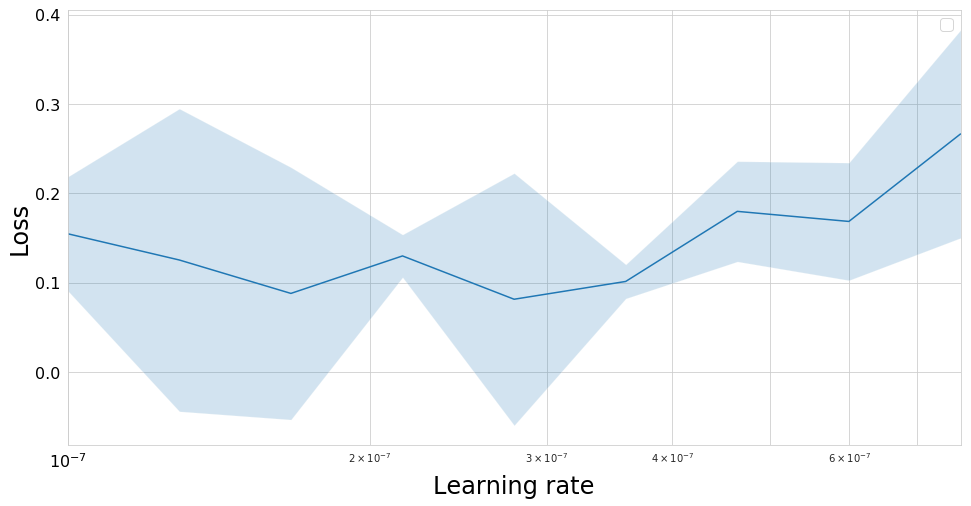

______________________________________



In [15]:
def my_model(**_):
    return model


newModelArgs = modelParams.copy()
newModelArgs['compileArgs'] = compileArgs.copy()
newModelArgs['compileArgs']['lr'] = 1e-3
trainParams['batch_size'] = 256
patience = 20  # is 50 above

loss = new_loss_functions['asimovSignificanceLossInvert_Sys0p5_S6d92ep02_B4d11ep05']
#loss = new_loss_functions['significanceLoss2Invert_S6d92ep02_B4d11ep05']
#loss = new_loss_functions['sOverBLossInvert_S2d01ep03_B1d20ep06']
#loss = new_loss_functions['sMinusBLossInvert_S2d01ep03_B1d20ep06']
newModelArgs['compileArgs']['lr'] = 1e-10
newModelArgs['compileArgs']['loss'] = loss
trainParams['batch_size'] = 8192

# d = trainData
d = trainDataTargetMod

lrFinder = batchLRFind(d, getModel, newModelArgs, trainParams,# allFolds=False,
                       lrBounds=[1e-7,1e-6], trainOnWeights=True, verbose=0, binary=True)

## Train classifier

<b>Asimov-significance-loss 0.5</b> training with ``maxEpochs``

In [27]:
def _get_s_b(s_exp, b_exp, y_true, y_pred):

    # unfold encoded weights
    weights = K.abs(y_true)
    s_weights = (weights + y_true)/2.
    b_weights = (weights - y_true)/2.

    s_exp_weight = s_exp/(K.sum(s_weights)+K.epsilon())
    b_exp_weight = b_exp/(K.sum(b_weights)+K.epsilon())

    s = s_exp_weight * K.sum(y_pred * s_weights)
    b = b_exp_weight * K.sum(y_pred * b_weights)
    return s, b


def asimovSignificanceLossInvert(syst_factr, s_exp=None, b_exp=None):
    '''Define a loss function that calculates the significance based on fixed
    expected signal and expected background yields for a given batch size

    s_exp and b_exp are the number of recorded signal and background events,
    respectively (xsec*lumi).'''

    #@_patch_with_weights
    def asimovSigLossInvert(y_true, y_pred):        
        # The problem with inner_loss is that it's not monotonic when using 
        # epsilons and numerically unstable otherwise. 
        # So for a given s, there's a b value at which the function is maximal,
        # after that value the function is falling and thus promoting more
        # background events to smaller loss values.

        # coding dataflow according to:
        # https://stackoverflow.com/questions/33712178/tensorflow-nan-bug/42497444#42497444

        s, b = _get_s_b(s_exp, b_exp, y_true, y_pred)
        s += K.epsilon()
        b += K.epsilon()

        # minimal background value for inner_loss to be on the safe side.
        def max_bkg(s):
            return K.pow(s, .65)*10./K.pow(syst_factr, 0.65)
        
        b_max = max_bkg(s)
        s_b_ok = K.greater(b_max, b)
        s_b_ok = K.print_tensor(s_b_ok, 's_b_ok=')
        sb = K.stack([s,b])
        sb = K.print_tensor(sb, 'sb=')

        # Asimov loss function
        def inner_loss(sb):
            s, b = sb[0], sb[1]
            spb = s+b
            b2 = b*b
            syst = syst_factr * b
            syst2 = syst*syst
            bpsyst2 = b+syst2            
            eps = K.epsilon()
            return 0.5/(
                spb * K.log((spb*bpsyst2)/(b2+spb*syst2+eps)+eps)
                -b2/(syst2+eps) * K.log(1+syst2*s/(b*bpsyst2+eps))
            )
    
        def safe_inner_loss(sb):
            # linear function, continuing from b_max on
            s, b = sb[0], sb[1]
            b_max = max_bkg(s)
            l_b_max     = inner_loss(K.stack([s,b_max     ]))
            l_b_max0p95 = inner_loss(K.stack([s,b_max*0.95]))
            l_b_max1p05 = inner_loss(K.stack([s,b_max*1.05]))

            # vals = K.stack([l_b_max0p95,l_b_max,l_b_max1p05])
            # vals = K.print_tensor(vals, 'l_b_max=')
            # l_b_max0p95,l_b_max,l_b_max1p05 = vals[0],vals[1],vals[2]

            slope = (l_b_max1p05-l_b_max0p95) / (b_max*0.1) 
            offset = l_b_max - slope*b_max
        
            return (slope*b + offset)

        loss = K.switch(s_b_ok, inner_loss(sb), safe_inner_loss(sb))
        
        # numerical instabilities for s < 0.5 => b/s/s
        s_min = 0.5
        s_at_low_bound = K.greater(s_min, s)
        s_at_low_bound = K.print_tensor(s_at_low_bound, 's_at_low_bound=')
        norm = inner_loss(K.stack([s_min,b])) / (b/s_min/s_min)
        loss = K.switch(s_at_low_bound, norm*b/s/s, loss)
        
        return loss

    return asimovSigLossInvert

    
def get_losses_dict(syst_factors, s_exp=None, b_exp=None):
    post_fix  = ('_S%.2e'%s_exp) if s_exp else ''
    post_fix += ('_B%.2e'%b_exp) if b_exp else ''
    for before, after in (('.', 'd'), ('+','p'), ('-','m')):
        post_fix = post_fix.replace(before, after)

    d = {}
    d.update({
        (
            ('asimovSignificanceLossInvert_Sys%s'%sf).replace('.','p')+post_fix,
                asimovSignificanceLossInvert(sf, s_exp, b_exp)
        )
        for sf in syst_factors
    })

    # for keras to find the find the functions on load, the need to be named
    for func_name, func in d.iteritems():
        func.__name__ = func_name

    return d


new_loss_functions.update(get_losses_dict([0.001, 0.1, 0.3, 0.5], s_exp, b_exp))

In [28]:
newModelArgs = modelParams.copy()
loss = new_loss_functions['asimovSignificanceLossInvert_Sys0p5_S6d92ep02_B4d11ep05']
#loss = new_loss_functions['significanceLoss2Invert_S9d58ep02_B2d08ep04']
newModelArgs['compileArgs']['lr'] = 1e-3
#newModelArgs['compileArgs']['l2'] = 0.2
#newModelArgs['compileArgs']['do'] = 0.2
newModelArgs['compileArgs']['loss'] = loss
trainParams['batch_size'] = 8192

Using cosine annealing
Training using weights
Running fold 1 / 10
.
1 New best found: 0.0542410654699
.
2 New best found: 0.0478524739104
.
3 New best found: 0.0435592257564
.
4 New best found: 0.036804762724
.
5 New best found: 0.0283671437199
.
6 New best found: 0.02382176776
.
7 New best found: 0.0226525318424
.
8 New best found: 0.0182378865211
.
9 New best found: 0.0146568385242
.
10 New best found: 0.0128291053572
.
11 New best found: 0.0116878562007
.
12 New best found: 0.0110440105084
.
13 New best found: 0.0107117916642
.
14 New best found: 0.0105680482081
.
15 New best found: 0.010525602933
.
16 New best found: 0.0100058385757
.
17 New best found: 0.00922298796168
.
18 New best found: 0.00824573695794
.
19 New best found: 0.00707238747574
.
20 New best found: 0.00575006266417
.
21 New best found: 0.00474510778947
.
22 New best found: 0.00412929573339
.
23 New best found: 0.00361386703844
.
24 New best found: 0.00325050628274
.
25 New best found: 0.00308948727258
.
26 New best

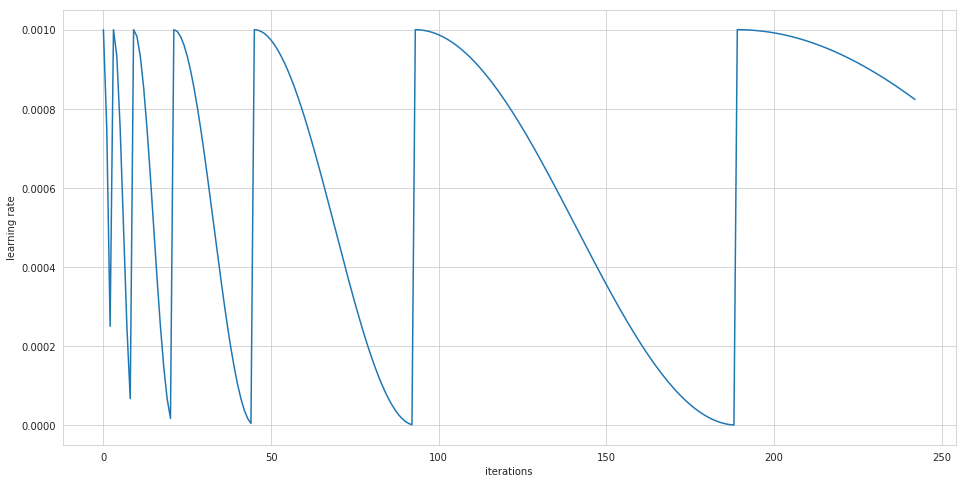

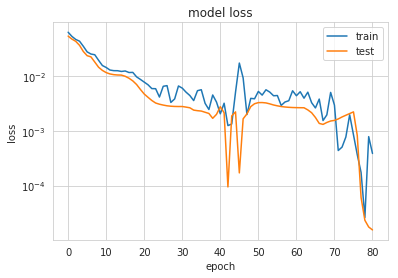

Fold took 91.272s

Running fold 2 / 10
.
1 New best found: 0.0502996288104
.
2 New best found: 0.0431258852751
.
3 New best found: 0.0381003538633
.
4 New best found: 0.03057870052
.
5 New best found: 0.0239536614971
.
6 New best found: 0.0216303089525
.
7 New best found: 0.0210330009278
.
8 New best found: 0.0187556466036
.
9 New best found: 0.0163450158752
.
10 New best found: 0.0147511861366
.
11 New best found: 0.0137962680927
.
12 New best found: 0.0132285249626
.
13 New best found: 0.0129269252236
.
14 New best found: 0.0127302504744
.
15 New best found: 0.0126852437055
.
16 New best found: 0.0118786199685
.
17 New best found: 0.0107008707249
.
18 New best found: 0.00945522686115
.
19 New best found: 0.0081855918499
.
20 New best found: 0.00710064792567
.
21 New best found: 0.00607498717984
.
22 New best found: 0.00517479599722
.
23 New best found: 0.00452819812683
.
24 New best found: 0.00417307162313
.
25 New best found: 0.0039701833905
.
26 New best found: 0.00386482842138
.
2

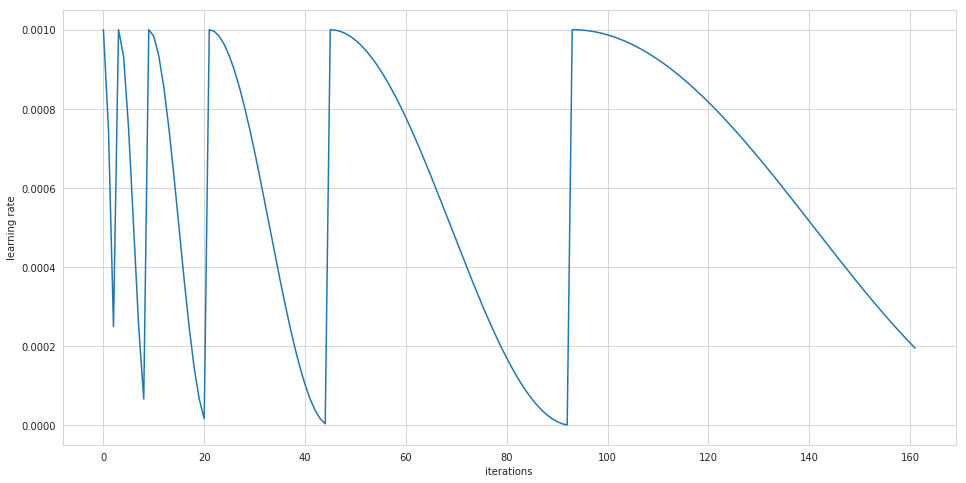

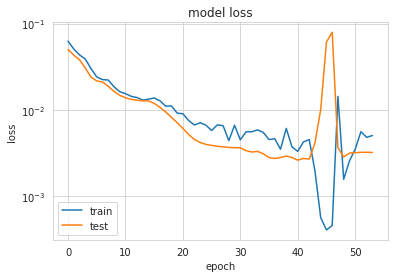

Fold took 59.852s

Running fold 3 / 10
.
1 New best found: 0.0497296866156
.
2 New best found: 0.0396518037908
.
3 New best found: 0.0338611249153
.
4 New best found: 0.0268401273148
.
5 New best found: 0.0209929935447
.
6 New best found: 0.0188286051797
.
7 New best found: 0.0182918526995
.
8 New best found: 0.016432197396
.
9 New best found: 0.0143897524966
.
10 New best found: 0.0130197292394
.
11 New best found: 0.0122016153629
.
12 New best found: 0.0116862372276
.
13 New best found: 0.0113386060004
.
14 New best found: 0.0111756416765
.
15 New best found: 0.0111079005915
.
16 New best found: 0.0101440685356
.
17 New best found: 0.00869874888081
.
18 New best found: 0.00730599330966
.
19 New best found: 0.00637007657908
.
20 New best found: 0.0056225078195
.
21 New best found: 0.00504209621698
.
22 New best found: 0.00450448943994
.
23 New best found: 0.0041843809352
.
24 New best found: 0.00402890189584
.
25 New best found: 0.0038902629419
.
26 New best found: 0.00376093245521
.


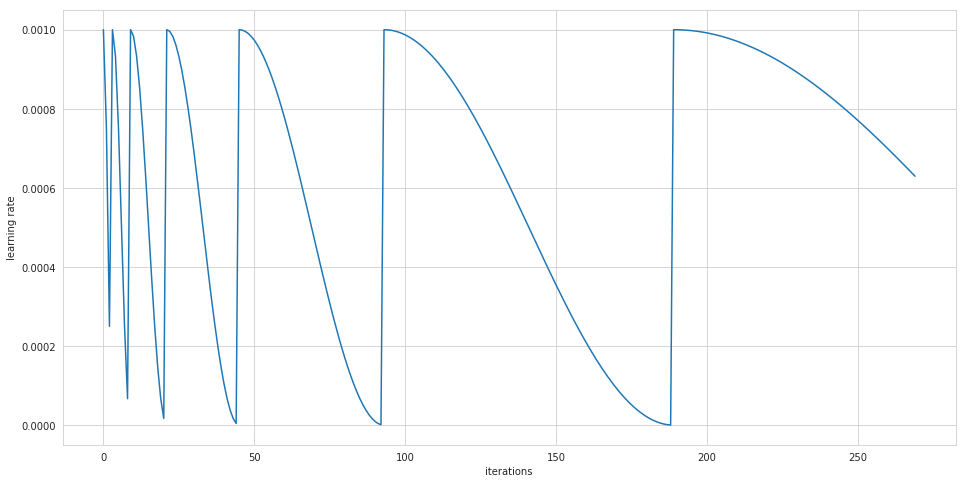

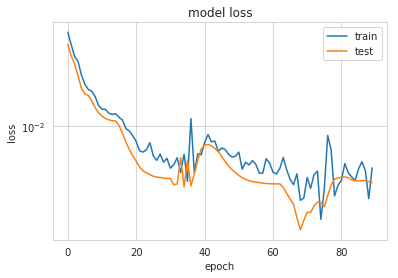

Fold took 98.473s

Running fold 4 / 10
.
1 New best found: 0.0437368639708
.
2 New best found: 0.0342714161098
.
3 New best found: 0.0290986032248
.
4 New best found: 0.0239164834023
.
5 New best found: 0.0199478439808
.
6 New best found: 0.0184102524966
.
7 New best found: 0.0179999282897
.
8 New best found: 0.016455642879
.
9 New best found: 0.0145637308523
.
10 New best found: 0.0132510169178
.
11 New best found: 0.0124405531123
.
12 New best found: 0.0118718825459
.
13 New best found: 0.0114928809956
.
14 New best found: 0.0113198029354
.
15 New best found: 0.0112459049627
.
16 New best found: 0.0103069465443
.
17 New best found: 0.0089092015624
.
18 New best found: 0.00763916002065
.
19 New best found: 0.00654330941513
.
20 New best found: 0.00586622623131
.
21 New best found: 0.00543305704221
.
22 New best found: 0.00502866303399
.
23 New best found: 0.00481145164445
.
24 New best found: 0.00479038560838
.
25 New best found: 0.00462309620157
.
26 New best found: 0.00448407079354


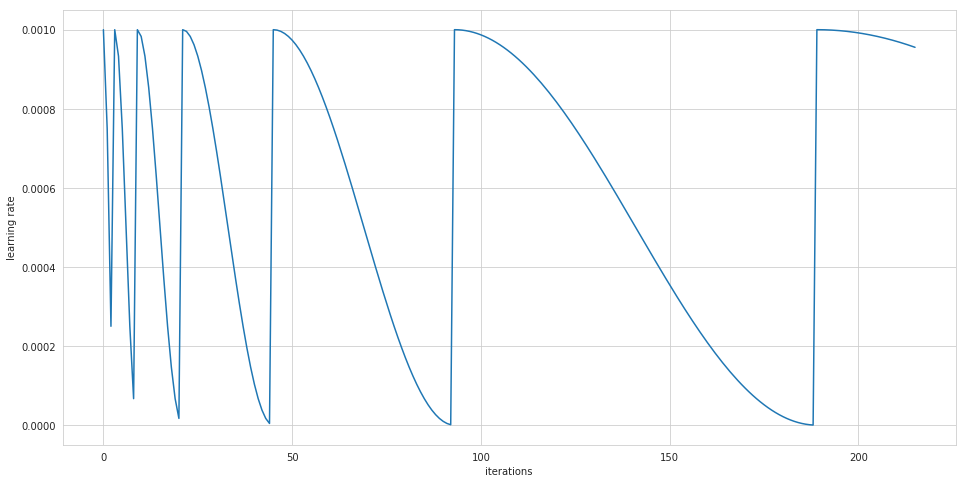

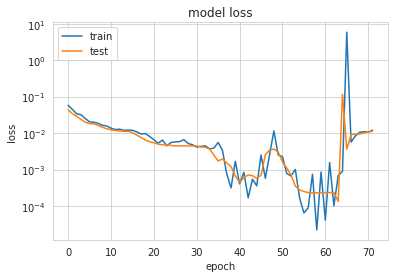

Fold took 81.131s

Running fold 5 / 10
.
1 New best found: 0.0507382189572
.
2 New best found: 0.037641145134
.
3 New best found: 0.0289906874835
.
4 New best found: 0.021637654832
.
5 New best found: 0.0179301409125
.
6 New best found: 0.0165501279861
.
7 New best found: 0.0161444410861
.
8 New best found: 0.0146986008465
.
9 New best found: 0.0135880860701
.
10 New best found: 0.0128407188118
.
11 New best found: 0.0120277053177
.
12 New best found: 0.0114233465478
.
13 New best found: 0.0109707776845
.
14 New best found: 0.0107602260426
.
15 New best found: 0.0106946191102
.
16 New best found: 0.00959675565213
.
17 New best found: 0.00795490930304
.
18 New best found: 0.00647924224511
.
19 New best found: 0.00557238523215
.
20 New best found: 0.00507844260037
.
21 New best found: 0.00477887354195
.
22 New best found: 0.00431117117852
.
23 New best found: 0.00396820056736
.
24 New best found: 0.00381379606016
.
25 New best found: 0.00344782287218
.
26 New best found: 0.00329180917926

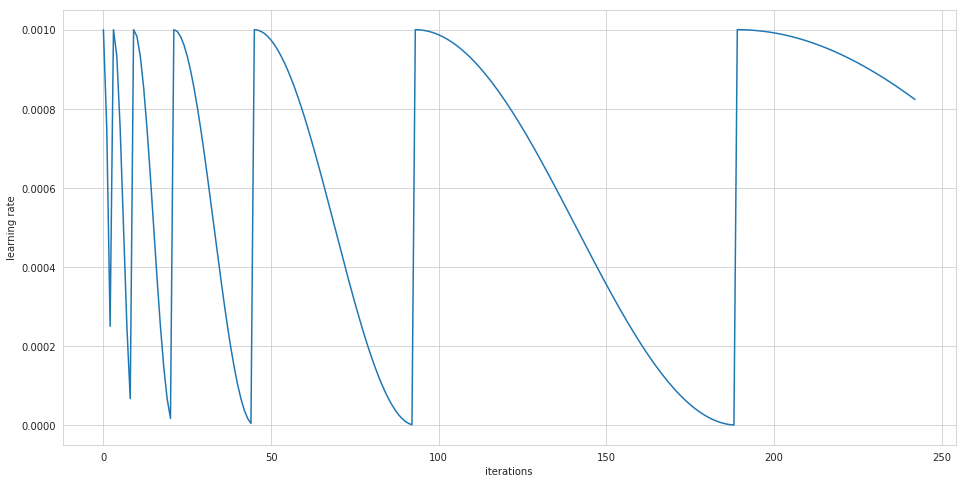

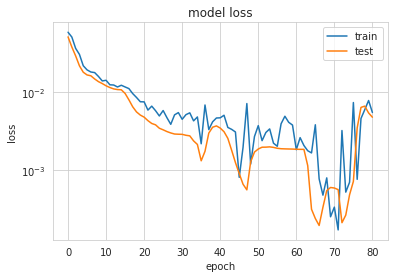

Fold took 88.600s

Running fold 6 / 10
.
1 New best found: 0.046363545078
.
2 New best found: 0.0365489724815
.
3 New best found: 0.0322663874567
.
4 New best found: 0.0266272141725
.
5 New best found: 0.0212252407581
.
6 New best found: 0.0189790358424
.
7 New best found: 0.0184578826368
.
8 New best found: 0.0166521091104
.
9 New best found: 0.0150953895926
.
10 New best found: 0.0140600775525
.
11 New best found: 0.0131278216213
.
12 New best found: 0.0124430229574
.
13 New best found: 0.0120691109136
.
14 New best found: 0.0118867841288
.
15 New best found: 0.0118306814194
.
16 New best found: 0.0111677395537
.
17 New best found: 0.0103281234249
.
18 New best found: 0.00949748738706
.
19 New best found: 0.00856562248021
.
20 New best found: 0.00764667721987
.
21 New best found: 0.00692534153983
.
22 New best found: 0.00638803103417
.
23 New best found: 0.00601029245332
.
24 New best found: 0.00574557347894
.
25 New best found: 0.00554134733826
.
26 New best found: 0.0054082345888
.

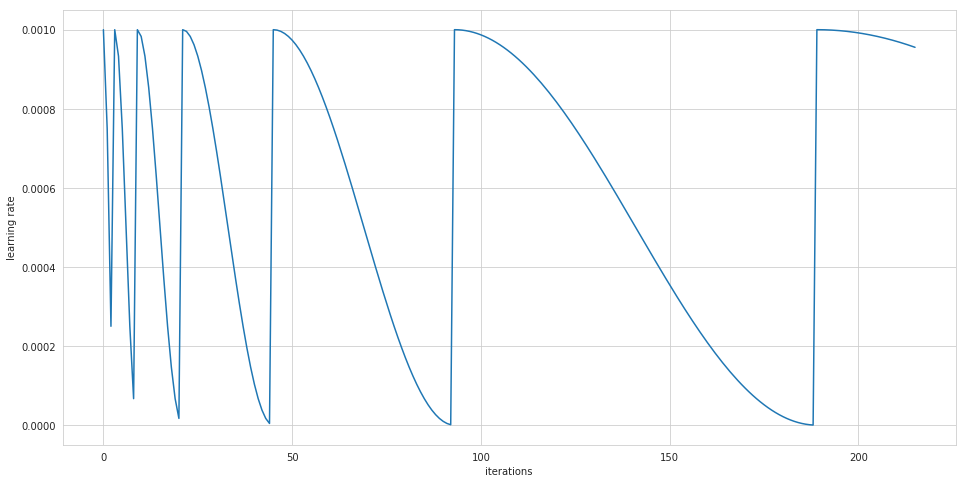

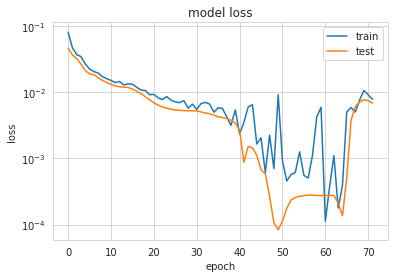

Fold took 79.879s

Running fold 7 / 10
.
1 New best found: 0.0574681561589
.
2 New best found: 0.0508486846626
.
3 New best found: 0.0448937583447
.
4 New best found: 0.0337838978708
.
5 New best found: 0.0237807501405
.
6 New best found: 0.0208256949544
.
7 New best found: 0.0201675979704
.
8 New best found: 0.017834242329
.
9 New best found: 0.0153607798398
.
10 New best found: 0.0136069017321
.
11 New best found: 0.0126049178362
.
12 New best found: 0.0120426410541
.
13 New best found: 0.0117241410464
.
14 New best found: 0.0115792865187
.
15 New best found: 0.0115342419073
.
16 New best found: 0.0107272343218
.
17 New best found: 0.00944692707509
.
18 New best found: 0.00812621082515
.
19 New best found: 0.00700450249389
.
20 New best found: 0.00614695681483
.
21 New best found: 0.00545081461668
.
22 New best found: 0.00481464128718
.
23 New best found: 0.0043990349099
.
24 New best found: 0.00419109163731
.
25 New best found: 0.00403875944316
.
26 New best found: 0.00401072038785


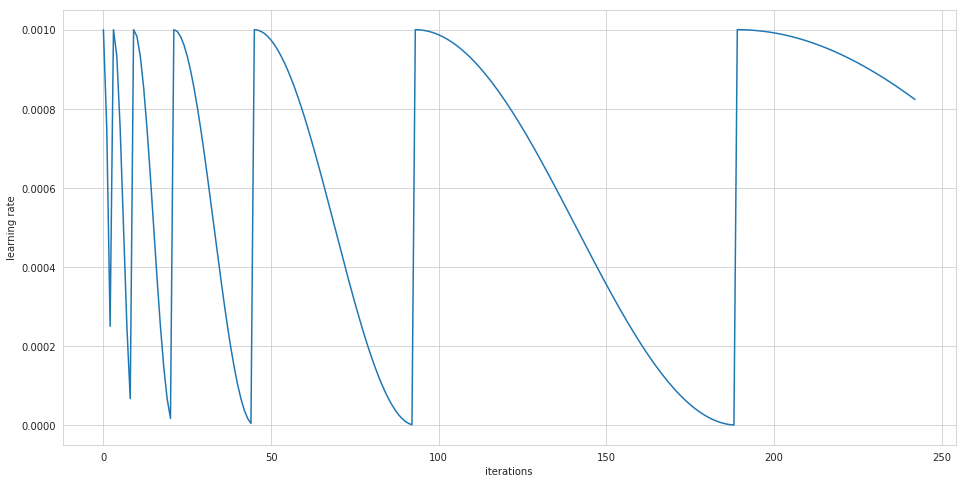

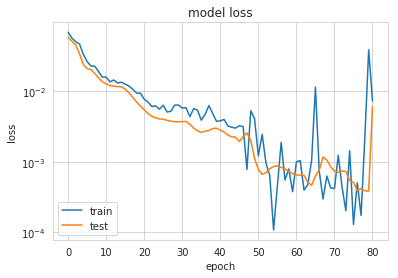

Fold took 87.374s

Running fold 8 / 10
.
1 New best found: 0.0538413060158
.
2 New best found: 0.044357605177
.
3 New best found: 0.0390493154257
.
4 New best found: 0.0322287913787
.
5 New best found: 0.025553570166
.
6 New best found: 0.0226036661237
.
7 New best found: 0.0218409336295
.
8 New best found: 0.0192331596107
.
9 New best found: 0.0168350334001
.
10 New best found: 0.0152817574661
.
11 New best found: 0.0141652488987
.
12 New best found: 0.0134755757718
.
13 New best found: 0.0131425919768
.
14 New best found: 0.0129799698618
.
15 New best found: 0.0129207116106
.
16 New best found: 0.0123056153373
.
17 New best found: 0.011382213102
.
18 New best found: 0.0104567952689
.
19 New best found: 0.00944898950515
.
20 New best found: 0.00836734241869
.
21 New best found: 0.00728247617927
.
22 New best found: 0.00639070362625
.
23 New best found: 0.00574427274693
.
24 New best found: 0.00533561189208
.
25 New best found: 0.00502488137036
.
26 New best found: 0.00483542228083
.
2

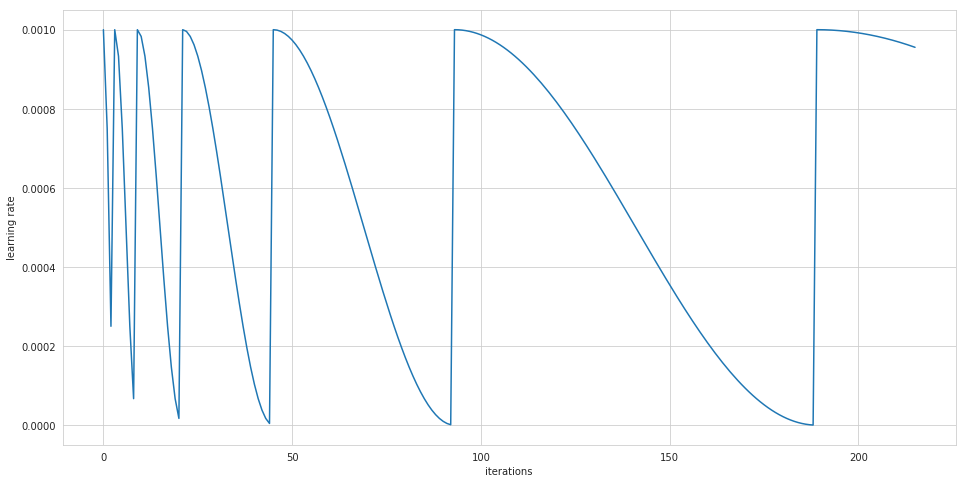

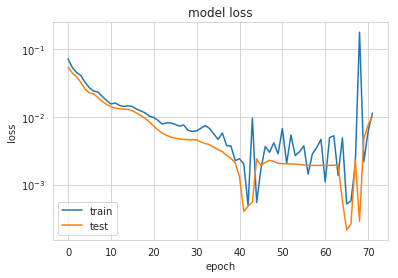

Fold took 81.701s

Running fold 9 / 10
.
1 New best found: 0.0486780830464
.
2 New best found: 0.0389936686689
.
3 New best found: 0.0323127279849
.
4 New best found: 0.0249601794035
.
5 New best found: 0.0206108975122
.
6 New best found: 0.0190848511857
.
7 New best found: 0.0185877388579
.
8 New best found: 0.0163834974932
.
9 New best found: 0.0146613417691
.
10 New best found: 0.0136926809756
.
11 New best found: 0.012892204285
.
12 New best found: 0.0122946772643
.
13 New best found: 0.0119794634186
.
14 New best found: 0.0118027431592
.
15 New best found: 0.0117521194784
.
16 New best found: 0.011040796587
.
17 New best found: 0.00992620951926
.
18 New best found: 0.00854666265553
.
19 New best found: 0.00724684126321
.
20 New best found: 0.00632481042976
.
21 New best found: 0.00537455192319
.
22 New best found: 0.00471029866655
.
23 New best found: 0.00410891870362
.
24 New best found: 0.00358892643
.
25 New best found: 0.00322741666982
.
26 New best found: 0.00297708423888
.
2

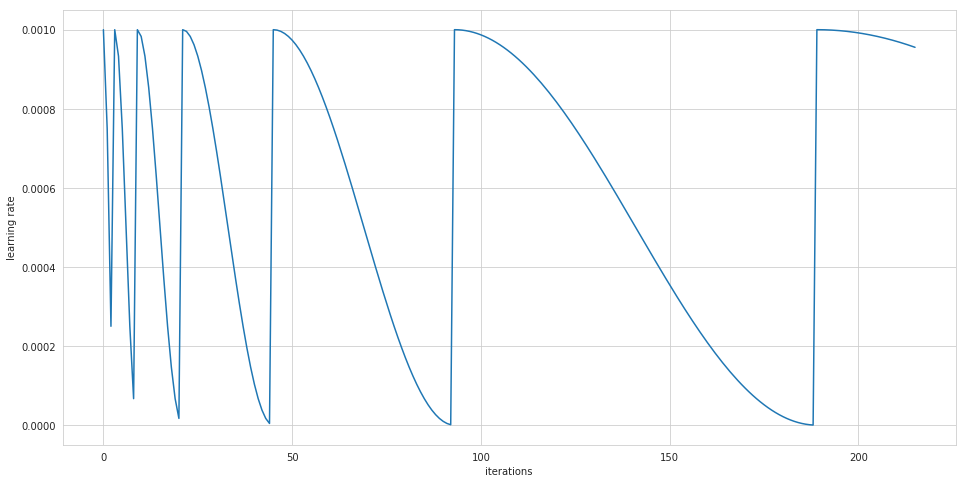

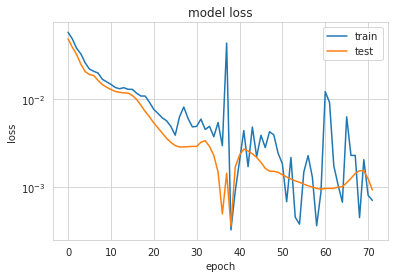

Fold took 80.480s

Running fold 10 / 10
.
1 New best found: 0.0469527342757
.
2 New best found: 0.0360162654928
.
3 New best found: 0.0302280574686
.
4 New best found: 0.0239962514357
.
5 New best found: 0.0191842978798
.
6 New best found: 0.0173399883512
.
7 New best found: 0.0168968589343
.
8 New best found: 0.015139289974
.
9 New best found: 0.0132358879124
.
10 New best found: 0.0119923736655
.
11 New best found: 0.0111746349385
.
12 New best found: 0.0106455969954
.
13 New best found: 0.0103486038636
.
14 New best found: 0.0101905824225
.
15 New best found: 0.0101455476347
.
16 New best found: 0.00949481131896
.
17 New best found: 0.00852322858083
.
18 New best found: 0.0075892628015
.
19 New best found: 0.00687344500888
.
20 New best found: 0.0063844098526
.
21 New best found: 0.00601271363467
.
22 New best found: 0.00572068293668
.
23 New best found: 0.00547055338886
.
24 New best found: 0.00526978008178
.
25 New best found: 0.00514046444321
.
26 New best found: 0.00506356436626

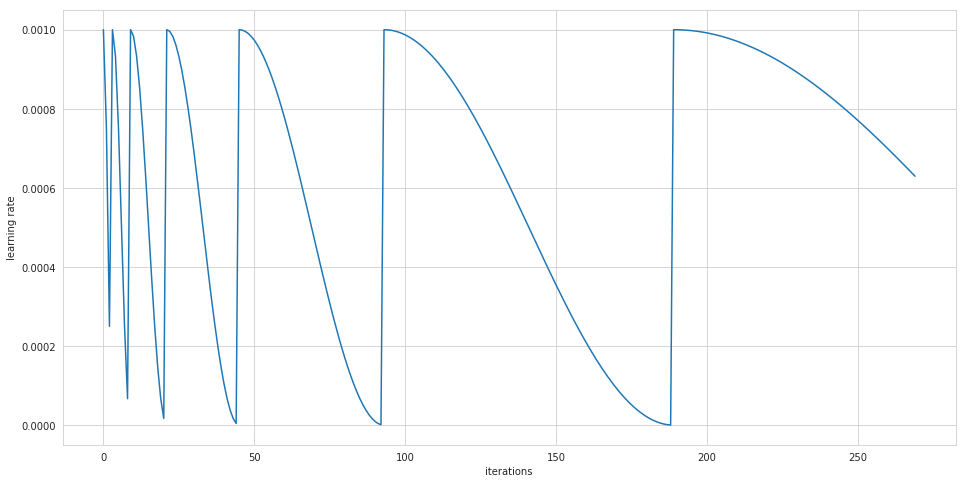

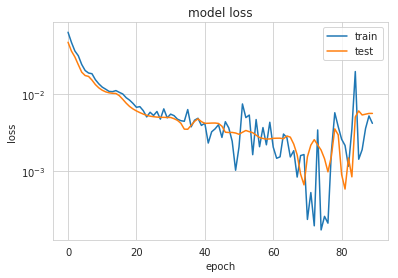

Fold took 95.797s


______________________________________
Training finished
Cross-validation took 846.414s 
Mean loss = 0.0006 +- 0.0002
Mean AUC = 0.261 +- 0.004
Mean cut = 0.003 +- 0.003
Mean wAUC = 0.18 +- 0.004
Mean AMS = 1.98 +- 0.1
______________________________________



In [29]:
results, histories = batchTrainClassifier(trainDataTargetMod, nSplits, getModel, newModelArgs,
                                          trainParams, trainOnWeights=True, maxEpochs=maxEpochs,
                                          cosAnnealMult=2, reduxDecay=1,  # this line added
                                          patience=patience, verbose=1, amsSize=250000, binary=True,
                                          plotLR=plot_while_training, # plotMomentum=plot_while_training, 
                                          plot=plotLoss, 
                                          stopIfStallingTest=35,
                                         )

In [30]:
n = name_pretrain+'_model_step3p1'

In [31]:
#model.save(n+'.h5')
with open(n+'.pkl', 'w') as f:
    pickle.dump((results, histories), f)

In [8]:
#model = load_model(n+'.h5', custom_objects=new_loss_functions)
with open(n+'.pkl') as f:
    results, histories = pickle.load(f)

In [ ]:
for i in range(len(histories)):
    plotLoss(histories[i])

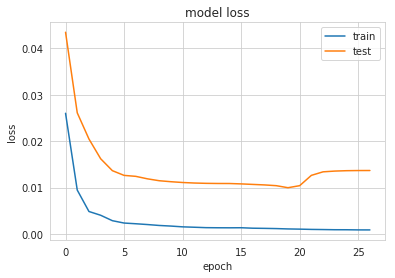

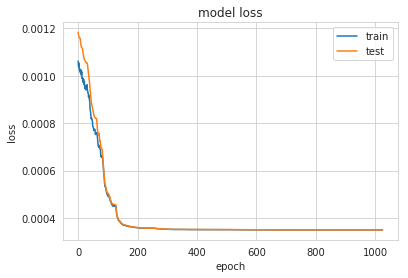

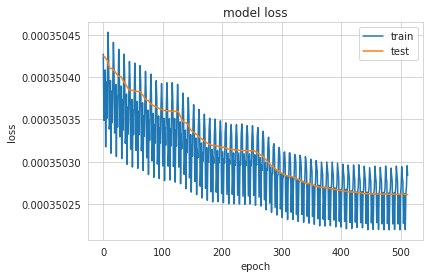

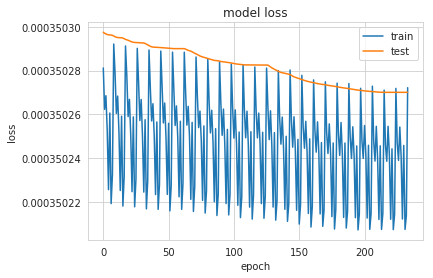

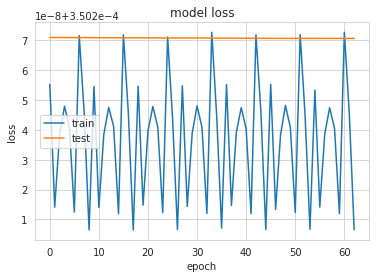

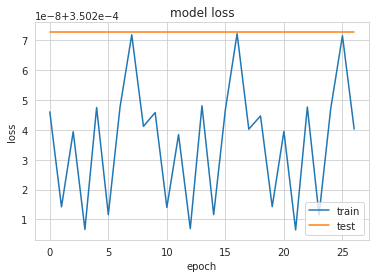

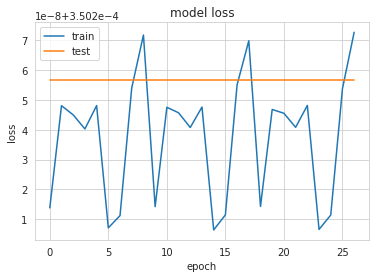

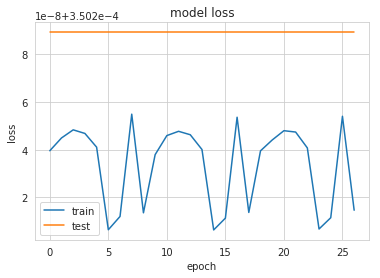

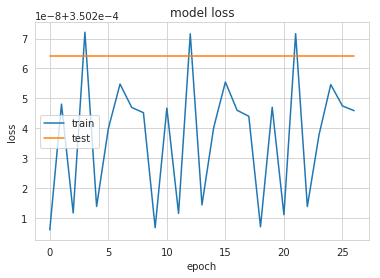

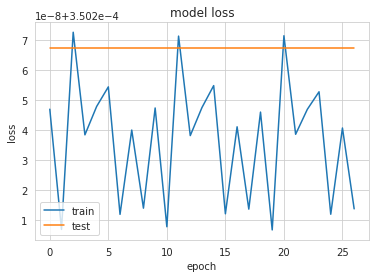

## Construct ensemble

In [19]:
with open('train_weights/resultsFile.pkl', 'rb') as fin:
    results = pickle.load(fin)

In [20]:
ensemble, weights = assembleEnsemble(
    results, ensembleSize, ensembleMode, compileArgs, custom_objects=new_loss_functions)

('Choosing ensemble by', 'loss')
('Model', 0, 'is', 1, 'with', 'loss', '=', 7.218596854037185e-05)
('Model', 1, 'is', 0, 'with', 'loss', '=', 7.28222043902639e-05)
('Model', 2, 'is', 3, 'with', 'loss', '=', 0.00010844440221553668)
('Model', 3, 'is', 4, 'with', 'loss', '=', 0.00026293573342263697)
('Model', 4, 'is', 7, 'with', 'loss', '=', 0.0002691071427234666)
('Model', 5, 'is', 6, 'with', 'loss', '=', 0.00047678187917917967)
('Model', 6, 'is', 5, 'with', 'loss', '=', 0.0005274492571130394)
('Model', 7, 'is', 8, 'with', 'loss', '=', 0.001656535768327881)
('Model', 8, 'is', 2, 'with', 'loss', '=', 0.003763624034261545)
('Model', 9, 'is', 9, 'with', 'loss', '=', 0.00456466931595268)


In [32]:
ensemble, weights = assembleEnsemble(
    results, ensembleSize, ensembleMode, compileArgs, custom_objects=new_loss_functions)

('Choosing ensemble by', 'loss')
('Model', 0, 'is', 2, 'with', 'loss', '=', 2.239767166418324e-05)
('Model', 1, 'is', 5, 'with', 'loss', '=', 6.451554456725716e-05)
('Model', 2, 'is', 1, 'with', 'loss', '=', 9.851154523505756e-05)
('Model', 3, 'is', 8, 'with', 'loss', '=', 0.00012116336698726914)
('Model', 4, 'is', 7, 'with', 'loss', '=', 0.00019351614006837587)
('Model', 5, 'is', 0, 'with', 'loss', '=', 0.00025573088858738707)
('Model', 6, 'is', 4, 'with', 'loss', '=', 0.0002816932827234268)
('Model', 7, 'is', 9, 'with', 'loss', '=', 0.0014942326932394653)
('Model', 8, 'is', 3, 'with', 'loss', '=', 0.001546876187995076)
('Model', 9, 'is', 6, 'with', 'loss', '=', 0.0030278400048613548)


## Response on validation datawith no ensembling

In [21]:
valData = BatchYielder(h5py.File(dirLoc + 'val.hdf5', "r+"))

In [41]:
%%time
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=1, verbose=1)

Predicting batch 1 out of 10
Prediction took 7.48997688293e-05s per sample

Predicting batch 2 out of 10
Prediction took 7.20654010773e-05s per sample

Predicting batch 3 out of 10
Prediction took 7.72923946381e-05s per sample

Predicting batch 4 out of 10
Prediction took 4.63632106781e-05s per sample

Predicting batch 5 out of 10
Prediction took 3.98722171783e-05s per sample

Predicting batch 6 out of 10
Prediction took 4.95500087738e-05s per sample

Predicting batch 7 out of 10
Prediction took 5.20286083221e-05s per sample

Predicting batch 8 out of 10
Prediction took 5.01391887665e-05s per sample

Predicting batch 9 out of 10
Prediction took 6.17813587189e-05s per sample

Predicting batch 10 out of 10
Prediction took 6.38172149658e-05s per sample

CPU times: user 14.4 s, sys: 50.7 s, total: 1min 5s
Wall time: 2.95 s


In [42]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source))))

Testing ROC AUC: unweighted 0.709948963661, weighted 0.77034265833


In [11]:
%%time
amsScanSlow(convertToDF(valData.source))

(50000, 'candidates loaded')
CPU times: user 19.2 s, sys: 0 ns, total: 19.2 s
Wall time: 41.5 s


(3.574477842890102, 0.9527582)

In [12]:
%%time
bootstrapMeanAMS(convertToDF(valData.source), N=512)

(50000, 'candidates loaded')

Mean AMS=3.6+-0.1, at mean cut of 0.95+-0.01
Exact mean cut 0.947619539453, corresponds to AMS of 3.52228979407
CPU times: user 2.71 s, sys: 10 s, total: 12.7 s
Wall time: 57.8 s


(3.6, 0.95)

# Test scoring with no ensembling

In [20]:
testData = BatchYielder(h5py.File(dirLoc + 'testing.hdf5', "r+"))

In [21]:
%%time
batchEnsemblePredict(ensemble, weights, testData, ensembleSize=1, verbose=1)

Predicting batch 1 out of 10
Prediction took 3.52311047641e-05s per sample

Predicting batch 2 out of 10
Prediction took 3.53069262071e-05s per sample

Predicting batch 3 out of 10
Prediction took 3.40793089433e-05s per sample

Predicting batch 4 out of 10
Prediction took 3.57414549047e-05s per sample

Predicting batch 5 out of 10
Prediction took 4.16354005987e-05s per sample

Predicting batch 6 out of 10
Prediction took 3.62087639895e-05s per sample

Predicting batch 7 out of 10
Prediction took 3.70459816673e-05s per sample

Predicting batch 8 out of 10
Prediction took 3.47492521459e-05s per sample

Predicting batch 9 out of 10
Prediction took 3.80688537251e-05s per sample

Predicting batch 10 out of 10
Prediction took 3.47301613201e-05s per sample

CPU times: user 1min 44s, sys: 5min 43s, total: 7min 27s
Wall time: 20 s


In [44]:
scoreTestOD(testData.source, 0.9417530075879768)

Public:Private AMS: 3.18253691892 : 3.22240702412


(3.1825369189224144, 3.222407024124467)

## Response on validation data with ensembling

In [22]:
valData = BatchYielder(h5py.File(dirLoc + 'val.hdf5', "r+"))

In [23]:
%%time
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=ensembleSize, verbose=1)

Predicting batch 1 out of 10
Prediction took 0.00208602199554s per sample

Predicting batch 2 out of 10
Prediction took 0.000581909799576s per sample

Predicting batch 3 out of 10
Prediction took 0.00042538599968s per sample

Predicting batch 4 out of 10
Prediction took 0.000606828594208s per sample

Predicting batch 5 out of 10
Prediction took 0.000568887615204s per sample

Predicting batch 6 out of 10
Prediction took 0.000575028991699s per sample

Predicting batch 7 out of 10
Prediction took 0.00061313419342s per sample

Predicting batch 8 out of 10
Prediction took 0.000623775959015s per sample

Predicting batch 9 out of 10
Prediction took 0.000646561002731s per sample

Predicting batch 10 out of 10
Prediction took 0.000522941589355s per sample

CPU times: user 2min 32s, sys: 8min 43s, total: 11min 15s
Wall time: 36.3 s


In [45]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source))))

Testing ROC AUC: unweighted 0.776212423208, weighted 0.844021255325


In [19]:
amsScanSlow(convertToDF(valData.source))

(50000, 'candidates loaded')


(3.715117458996407, 0.9555341)

In [20]:
%%time
bootstrapMeanAMS(convertToDF(valData.source), N=512)

(50000, 'candidates loaded')

Mean AMS=3.8+-0.1, at mean cut of 0.95+-0.01
Exact mean cut 0.950024582446, corresponds to AMS of 3.69339872363
CPU times: user 2.59 s, sys: 9.73 s, total: 12.3 s
Wall time: 56.6 s


(3.8, 0.95)

# Test scoring

In [15]:
testData = BatchYielder(h5py.File(dirLoc + 'testing.hdf5', "r+"))

In [16]:
%%time
batchEnsemblePredict(ensemble, weights, testData, ensembleSize=ensembleSize, verbose=1)

Predicting batch 1 out of 10
Prediction took 0.000381626436927s per sample

Predicting batch 2 out of 10
Prediction took 0.000325065690821s per sample

Predicting batch 3 out of 10
Prediction took 0.000332086307352s per sample

Predicting batch 4 out of 10
Prediction took 0.000326267415827s per sample

Predicting batch 5 out of 10
Prediction took 0.000327129546079s per sample

Predicting batch 6 out of 10
Prediction took 0.000323580308394s per sample

Predicting batch 7 out of 10
Prediction took 0.000327063855258s per sample

Predicting batch 8 out of 10
Prediction took 0.000326154544137s per sample

Predicting batch 9 out of 10
Prediction took 0.000326552473415s per sample

Predicting batch 10 out of 10
Prediction took 0.000326488633589s per sample

CPU times: user 15min 57s, sys: 52min 37s, total: 1h 8min 35s
Wall time: 3min 2s


In [23]:
scoreTestOD(testData.source, 0.9394347775960341)

Public:Private AMS: 3.6170575304 : 3.61021225312


(3.6170575303988963, 3.610212253117004)

# Save/Load

In [46]:
saveEnsemble(name, ensemble, weights, compileArgs, overwrite=True)

TypeError: <function asimovSignificanceLossInvert_Sys0p5_S6d92ep02_B4d11ep05 at 0x7f3c323ee758> is not JSON serializable

In [6]:
ensemble, weights, compileArgs, _, _ = loadEnsemble(name, custom_objects=new_loss_functions)

# Plotting

(50000, 'candidates loaded')


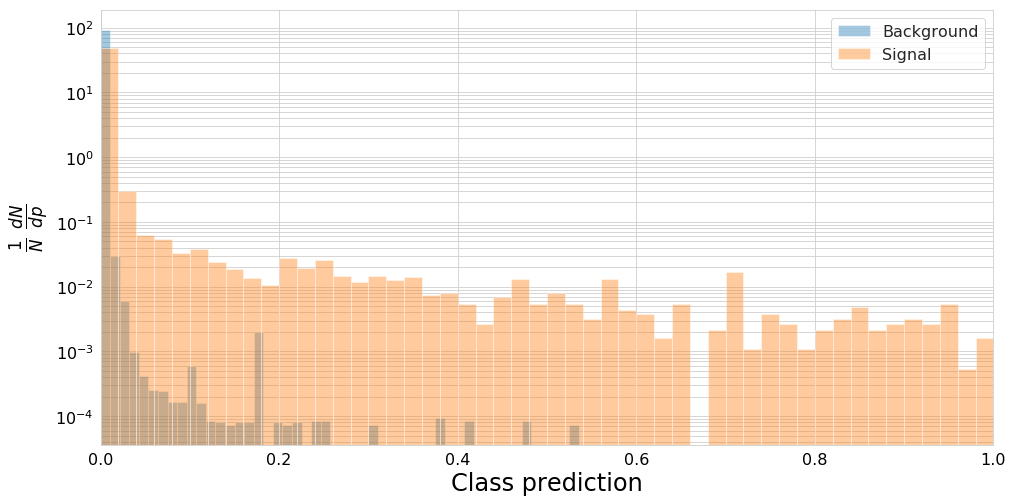

In [24]:
# TODO log-x

d = convertToDF(valData.source)
bkg_sig_dfs = [
    d[d['gen_target']==0],
    d[d['gen_target']==1],
]
getClassPredPlot(bkg_sig_dfs, weightName='gen_weight')

(50000, 'candidates loaded')
0 ROC AUC: 0.856223355087


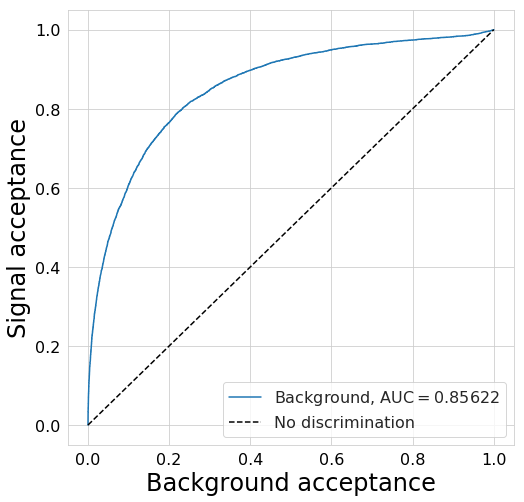

In [25]:
rocPlot([convertToDF(valData.source)], weightName='gen_weight', labels=['Background', 'Signal'])

(50000, 'candidates loaded')


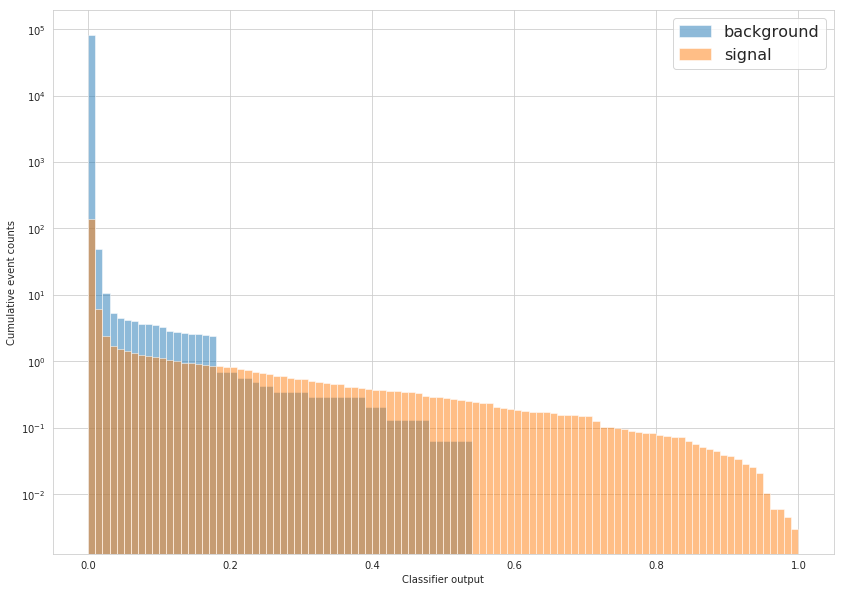

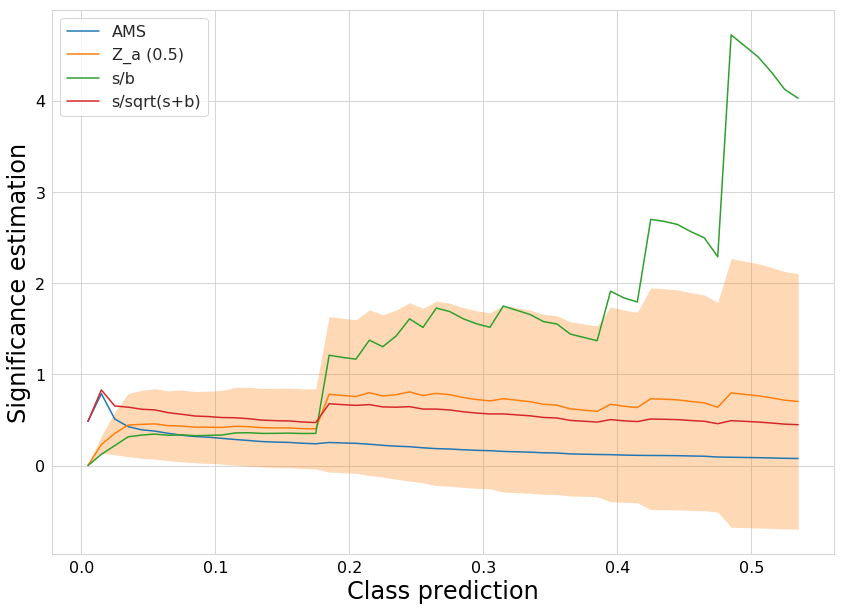

In [26]:
src = valData
#src = testData

from numpy import sqrt, log, power

def get_asimov(systematic):
    return lambda s,b: (Z_asimov(s,b, systematic), eZ_asimov(s,sqrt(s),b,sqrt(b),systematic))

h1 = plotSignificanceEstimate(
    convertToDF(src.source), 
    {
        's/b': lambda s,b: s/b,
        's/sqrt(s+b)': lambda s,b: s/np.sqrt(s+b),
        'Z_a (0.5)': get_asimov(0.5),
#        'Z_a (0.05)': get_asimov(0.05),
#        'Z_a (0.001)': get_asimov(0.001),
        'AMS': AMS,
#        'asimov err': lambda s,b: eZ(s,sqrt(s),b,sqrt(b)),
    },
    weightName='gen_weight',
    figsize=(14, 10),
    nBins=100,
)